In [1]:
class NodeValue(object):
    """
    Values and associated probability for that value of GraphNode object
    """
    def __init__(self, name=""):  
        self.name = name
        self.lambda_msg =  dict()
        self.pi_msg = dict()
        self.lambd = None
        self.pi = None
        self.CondProb_E = dict()
        self.Prob = None
        self.Prob_E = None
        self.CondProb = dict()

class GraphNode(object):
    """
    Graph Node in a directed graph
    """
    def __init__(self, name=""):
        """
        Construct a new node, and initialize the list of parents and children.
        Each parent/child is represented by a (key, value) pair in dictionary, 
        where key is the parent/child's name, and value is an GraphNode object.
        Args:
        name: node name (string).
        """
        self.name = name
        self.parents = dict()
        self.children = dict()
        self.values = dict()

    def add_parent(self, parent):
        """
        Args:
        parent: GraphNode object.
        """
        if not isinstance(parent, GraphNode):
            raise ValueError("Parent must be an instance of GraphNode class.")
        pname = parent.name
        self.parents[pname] = parent

    def add_child(self, child):
        """
        Args:
        child: GraphNode object.
        """
        if not isinstance(child, GraphNode):
            raise ValueError("Parent must be an instance of GraphNode class.")
        cname = child.name
        self.children[cname] = child

class BN(object):
    """
    Bayesian Network Class
    """
    def __init__(self):
        """
        Initialize list of nodes in the graph.
        Each node is represented by a (key, value) pair in dictionary, 
        where key is the node's name, and value is an set of GraphNode object
        """
        self.nodes = dict()
        self.E = dict()

    def add_edge(self, edge):
        """
        Add a directed edge to the graph.
        
        Args:
        edge: a tuple (A, B) representing a directed edge A-->B,
            where A, B are two strings representing the nodes' names
        """
        (pname, cname) = edge

        ## construct a new node if it doesn't exist
        if pname not in self.nodes:
            self.nodes[pname] = GraphNode(name=pname)
        if cname not in self.nodes:
            self.nodes[cname] = GraphNode(name=cname)

        ## add edge
        parent = self.nodes.get(pname)
        child = self.nodes.get(cname) 
        parent.add_child(child)
        child.add_parent(parent)
    
    def add_node_value(self, input_values, X):
        """
        Add different values a node(random variable) can take
        Args:
            input_values : Tuple such as ('0','1') with values
            any GraphNode of current BN can take.
        """
        for value in input_values:
            self.nodes[X].values[value] = NodeValue(name=value)
        
    def add_values(self, input_values):
        """
        Add different values each node(random variable) can take
        if all nodes have same input values
        Args:
            input_values : Tuple such as ('0','1') with values
            any GraphNode of current BN can take.
        """
        for node_name, node in self.nodes.items():
            add_node_value(input_values, node_name)
    
        
    def print_graph(self):
        """
        Visualize the current BN graph.
        """
        print("Bayes Network: ")
        for node_name, node in self.nodes.items():
            print("\tNode " + node_name)
            print("\tValues: " + str(node.values.keys()))
            print("\tParents: " + str(node.parents.keys()))
            print("\tChildren: " + str(node.children.keys()))
    
    def print_cpd(self, X):
        """
        Print probabilities assciated with the current BN graph.
        Args:
            X -> GraphNode object to print values 
        """
        for key, value in self.nodes[X].values.items():
            if(value.Prob != None):
                print("P(" + X + key + "): " + str(value.Prob))
            for Pkey, prob in value.CondProb_E.items():
                print("P("  + X + key + '|' + Pkey + "): " + str(prob))
        #end of print_cpd
    
    def print_values(self, X):    
        """
        Print all values(lambda, pi, messages) and probabilities assciated
        with input node of the current BN graph.
        Args:
            X -> GraphNode object to print values 
        """
        for key, value in self.nodes[X].values.items():
            if(value.lambd != None):
                print("lambda(" + X + key + "): " + str(value.lambd))
            if(value.pi != None):
                print("pi(" + X + key + "): " + str(value.pi))    
            for Vkey, val in value.lambda_msg.items():
                print("lambda msg("  + X + key + ') from ' + Vkey + ": " + str(val))
            for Vkey, val in value.pi_msg.items():
                print("pi msg("  + X + key + ') from ' + Vkey + ": " + str(val))
            if(value.Prob != None):
                print("P(" + X + key + "): " + str(value.Prob))
            if(value.Prob_E != None):
                print("P_E(" + X + key + "): " + str(value.Prob_E))
            for Pkey, prob in value.CondProb.items():
                print("P("  + X + key + '|' + Pkey + "): " + str(prob))
            for Pkey, prob in value.CondProb_E.items():
                print("P("  + X + key + '|' + Pkey + "): " + str(prob))
        #end of print_value
        
    
    def input_cpd(self, file):
        """
        To input all the associated given probabilities for the
        current BN from a file.
        Args:
            file : file object to read CPD from.
        """
        Replace = ["\n"," ","P","(",")"] ##Substrings to strip from given Probability string
        for line in file:
            for substring in Replace:
                line = line.replace(substring,"")
            prob = line.split("=")
            if(prob[0].find('|') == -1):
                ## Assign the given marginal probabilty for the input GraphNode value
                self.nodes[prob[0][0]].values[prob[0][1]].Prob = float(prob[1])
                ## Calculate the other probability from the given marginal probability and assign
                self.nodes[prob[0][0]].values[str(1-int(prob[0][1]))].Prob = 1-float(prob[1])
                continue
            Prob_string = prob[0].split("|")
            ## Assign the given conditional probabilty for the input GraphNode value
            self.nodes[Prob_string[0][0]].values[Prob_string[0][1]].CondProb[Prob_string[1]] = float(prob[1])
            ## Calculate the other conditional probability from the given marginal probability and assign
            self.nodes[Prob_string[0][0]].values[str(1-int(prob[0][1]))].CondProb[Prob_string[1]] = 1-float(prob[1])
              
            
    def send_lambda_msg(self, Y, X, iter=None):              
        """
        Send lamdba message from Y(child) to X(parent)
        and update the associated lambda/pi values
        for the current BN.
        Args:
            Y -> child GraphNode 
            X -> parent GraphNode 
        """ 
                
        if(iter == None):
            iter = 0
        ## check for Max iter limit
        if(iter == 5):
            return
        iter += 1
        
        alpha = 0.
        
        ## For all values of 'X', update the lambda message
        ## received from 'Y' and calculate lambda value
        for Xkey, Xval in self.nodes[X].values.items():
            Xval.lambda_msg[Y] = 0
            for Ykey, Yval in self.nodes[Y].values.items():
                lambda_sum = 0 ## Sum of the internediate values
                for ProbKey, Prob in Yval.CondProb.items():
                    pi_product = 1. ## To keep product of the required Pi msg
                    ## 'Y' Conditional Probability due to parents other than 'X'
                    if(ProbKey.find(X+Xkey) != -1):
                        for msgkey, msg in Yval.pi_msg.items():
                            ## product of Pi Msg from all other node then X
                            if(ProbKey.find(msgkey) != -1 and msgkey.find(X) == -1):
                                pi_product *= msg 
                        lambda_sum += Prob*pi_product
                Xval.lambda_msg[Y] += lambda_sum*Yval.lambd
            
            ## Calculate lamdba value by multiplying the lambda message
            ## received from all the childs[U] of Y
            Xval.lambd = 1
            for msgkey, msg in Xval.lambda_msg.items():
                Xval.lambd *= msg
                
            ## Calculate the updated marginal/conditional probability
            ## by multiplying assocaited lambda and pi values
            if(Xval.pi != None):
                Xval.Prob_E = Xval.lambd*Xval.pi
                alpha += Xval.Prob_E            
        
        ## Normalize the probabilities obtained to make it proper
        for key, Xval in self.nodes[X].values.items():
            if(alpha !=0):
                string = ''
                for strkey,value in self.E.items(): string +=strkey+str(value)+','
                ## if evidence set is 'Null', the probability obtained is marginal probability
                if(string[:-1]==""):
                    Xval.Prob = ((Xval.Prob_E)/alpha)
                else:
                    ## update the conditional prob for given evidence
                    Xval.CondProb_E[string[:-1]] = (Xval.Prob_E)/alpha
            else:
                ## handling case when alpha and calculated probability are both 'zero'
                if(Xval.Prob_E == 0):
                    string = ''
                    for strkey,value in self.E.items(): string +=strkey+str(value)+','
                    if(string[:-1]==""):
                        Xval.Prob = 0
                    else:
                        Xval.CondProb_E[string[:-1]] = 0
        
        ## Update the assocaited values for parents[Z] of X
        ## by sending the lambda message
        for Z in self.nodes[X].parents:
            if(Z not in self.E.keys()):
                self.send_lambda_msg(X, Z, iter=iter)
                
        ## Update the assocaited values for children of X
        ## other than 'Y' by sending the pi message
        for U in self.nodes[X].children:
            if ( U == Y):
                continue
            else:
                self.send_pi_msg(X, U, iter=iter)

    ## end of send_lambda_msg
                
    def send_pi_msg(self, Z, X, iter=None):
        """
        Send pi message from X(child) to Z(parent)
        and update the associated lambda/pi values
        for the current BN.
        Args:
            X -> child GraphNode 
            Z -> parent GraphNode 
        """ 
        ## Calculate and update the pi message sent from 
        ## Z to X
        
        if(iter == None):
            iter = 0

        ## check for Max iter limit
        if(iter == 5):
            return
        iter += 1
        for key, Zval in self.nodes[Z].values.items():
            if(Zval.pi != None):
                for Xkey, Xval in self.nodes[X].values.items():
                    Xval.pi_msg[Z+key] = Zval.pi
                    for U in self.nodes[Z].children:
                        if(U == X):
                            continue
                        Xval.pi_msg[Z+key] *= Zval.lambda_msg[U]
        
        ## Caculate the pi value for from updated values
        if(X not in self.E.keys()):
            alpha = 0.
            for Xkey, Xval in self.nodes[X].values.items():
                Xval.pi = 0
                for ProbKey, Prob in Xval.CondProb.items():
                    pi_product = 1. 
                    for msgkey, msg in Xval.pi_msg.items():
                        if(ProbKey.find(msgkey) != -1):
                            pi_product *= msg 
                    Xval.pi += Prob*pi_product
                if(Xval.lambd != None and Xval.pi != None):
                    Xval.Prob_E = Xval.pi*Xval.lambd
                    alpha += Xval.Prob_E
            
            ## Normalize the probabilities obtained to make it proper
            for Xkey, Xval in self.nodes[X].values.items():
                if(alpha != 0):
                    string = ''
                    for strkey,value in self.E.items(): string +=strkey+str(value)+','
                    ## if evidence set is 'Null', the probability obtained is marginal probability
                    if(string[:-1]==""):
                        Xval.Prob = ((Xval.Prob_E)/alpha)
                    else:
                        Xval.CondProb_E[string[:-1]] = ((Xval.Prob_E)/alpha)
                else:
                    ## handling case when alpha and calculated probability are both 'zero'
                    if(Xval.Prob_E == 0):
                        string = ''
                        for strkey,value in self.E.items(): string +=strkey+str(value)+','
                        if(string[:-1]==""):
                            Xval.Prob = 0
                        else:
                            Xval.CondProb_E[string[:-1]] = 0
            
            ## Update the assocaited values for children of X
            ## by sending the pi message
            for Y in self.nodes[X].children:
                self.send_pi_msg(X, Y, iter=iter)
                    
        ## For GraphNode values having lambda value not 
        ## equal to '1', send lambda message to its parents 
        ## other than 'Z', to update the associated values
        for key, Xval in self.nodes[X].values.items():
            if (Xval.lambd != 1):
                for W in self.nodes[X].parents:
                    if(W == Z):
                        continue
                    elif(W not in self.E.keys()):
                        self.send_lambda_msg(X, W, iter=iter)
    #send_pi_msg end        
    
    def initialize_network(self):
        """
        Initialize the lambda/pi values and lambda/pi
        message for current BN.
        Args:
            None
        """ 
        ## Set the Evidence set to 'Null'
        self.E = dict()
        
        ## Make sure the associated values for all 
        ## GraphNodes in current BN are set to default
        for node_name, node in self.nodes.items():
            for key, val in self.nodes[node_name].values.items():
                val.CondProb_E = {}
                val.Prob_E = None
                val.pi_msg = {}
                val.lambda_msg = {}
        
        ## Intialize lambda value to 1 for all and send pi/
        ## lambda message to current GrpahNode's children and parents
        for node_name, node in self.nodes.items():
            for key, val in self.nodes[node_name].values.items():
                val.lambd = 1
            for Zkey, Z in node.parents.items():
                for key, Zval in self.nodes[Zkey].values.items():
                    Zval.lambda_msg[node_name] = 1
            for Y in node.children:
                for Xkey, Xval in self.nodes[node_name].values.items():
                    for key, Yval in self.nodes[Y].values.items():
                        Yval.pi_msg[node_name+Xkey]=1
        
        ## For all the Root nodes (with no parent),
        ## update the pi value to marginal probability
        ## and send pi message to children of root node
        for node_name, node in self.nodes.items():
            if(node.parents == {}):
                for key, val in self.nodes[node_name].values.items():
                    val.pi = val.Prob
                    val.Prob_E = val.Prob
                for W in node.children:
                    self.send_pi_msg(node_name, W)

    ## end of initialize_network
                    
    def update_network(self, V, v):
        """
        Update the current BN for the instantiated Node and values
        Args:
            V: Char such as 'A', the instantiated GraphNode
            v: int, the instantiated value (0,1, etc)
        """ 
        V_dict = dict()
        V_dict[V] = v
        ## Update the evidennce set associated to include the
        ## instantiated GraphNode and value
        self.E.update(V_dict)
        
        ## Update the lambda and pi values for the instantiated
        if(V in self.nodes):  
            for key, val in self.nodes[V].values.items():
                ## Assign '1' to labda and pi value for the instantiated value
                if(val.name == str(v)):
                    val.lambd = 1
                    val.pi = 1
                    string = ''
                    for strkey,value in self.E.items(): string +=strkey+str(value)+','
                    if(string[:-1]==""):
                        val.Prob = 1
                    else:
                        val.CondProb_E[string[:-1]] = 1
                else:
                    ## Assign '0' to labda and pi value for the non-observed value
                    val.lambd = 0
                    val.pi = 0
                    string = ''
                    for strkey,value in self.E.items(): string +=strkey+str(value)+','
                    if(string[:-1]==""):
                        val.Prob = 0
                    else:
                        val.CondProb_E[string[:-1]] = 0
                        
            ## Send lambda message to all parents of
            ## 'V' which are not observed (not in E)
            for Z in self.nodes[V].parents:
                if (Z not in self.E.keys()):
                    self.send_lambda_msg(V, Z)
                    
            ## Send pi message to all children of 'V'
            for Y in self.nodes[V].children:
                self.send_pi_msg(V, Y)
            
    ## end of update_network

In [2]:
## Create new BN
myBN = BN()
file = open('Child-graph.txt', 'r') ## open file to retrieve edges of the graph
## read info from *.txt file
for line in file:
    line = line.replace("\n","") #remove '\n' return character at end of line 
    line = line.replace("|","") #remove '|' char in line
    line = line.replace("\t"," ") # replace double spaces with single for easier line parsing
    #spliting the input edge nodes
    edge = line.split(" ")
    ## add edges to Graph
    myBN.add_edge(edge)
file.close()

In [3]:
myBN.print_graph()

Bayes Network: 
	Node BirthAsphyxia
	Values: dict_keys([])
	Parents: dict_keys([])
	Children: dict_keys(['Disease'])
	Node Disease
	Values: dict_keys([])
	Parents: dict_keys(['BirthAsphyxia'])
	Children: dict_keys(['Sick', 'LungParench', 'DuctFlow', 'CardiacMixing', 'LVH', 'LungFlow', 'Age'])
	Node Sick
	Values: dict_keys([])
	Parents: dict_keys(['Disease'])
	Children: dict_keys(['Age', 'Grunting'])
	Node LungParench
	Values: dict_keys([])
	Parents: dict_keys(['Disease'])
	Children: dict_keys(['HypoxiaInO2', 'Grunting', 'CO2', 'ChestXray'])
	Node DuctFlow
	Values: dict_keys([])
	Parents: dict_keys(['Disease'])
	Children: dict_keys(['HypDistrib'])
	Node CardiacMixing
	Values: dict_keys([])
	Parents: dict_keys(['Disease'])
	Children: dict_keys(['HypoxiaInO2', 'HypDistrib'])
	Node LVH
	Values: dict_keys([])
	Parents: dict_keys(['Disease'])
	Children: dict_keys(['LVHreport'])
	Node LungFlow
	Values: dict_keys([])
	Parents: dict_keys(['Disease'])
	Children: dict_keys(['ChestXray'])
	Node Ag

In [4]:
## Open .net file to retrieve the values the nodes in graph can take
with open("child.net") as file:
    data = file.readlines()
line = 0
Replace = ["\n",";","=","\"","P","(",")","states"] ##Substrings to strip from given Probability string

## parsing the file and adding associated values for all nodes
while(line < len(data)):
    ## if 'node' keyword is found
    if(data[line].find('node') != -1):
        datastr = (data[line]).split()
        node_name = datastr[1]
        line += 2 ## .net file has states 2 lines after the node name
        for substring in Replace:
            ##remove the unnecessary chars for easier parsing
            data[line] = data[line].replace(substring,"")
        ## split line to add values to a list
        values = data[line].split()
        myBN.add_node_value(values, node_name) ## add the values to corresponding node
    else:
        line += 1 ##update the line number

In [5]:
## Open .bif file to retrieve the probabilities for the nodes in BN
with open("child.bif") as file:
    data = file.readlines()
line = 0
Replace = ["\n",";","=","\"","{","}","(",")","probability",","] ##Substrings to strip from given Probability string
while(line < len(data)):
    ## if 'probability' keyword is found in line
    if(data[line].find('probability') != -1):
        for substring in Replace:
            data[line] = data[line].replace(substring,"")
        datastr = (data[line]).split()
        ## first element in list is the node name for which CPD are given
        node_name = datastr[0] 
        obs_node = datastr[2:] ## remove the first two elements, node_name and "|"
    elif(data[line].find('}') != -1):
        pass
    else:
        ##remove the unnecessary chars for easier parsing
        for substring in Replace:
            data[line] = data[line].replace(substring,"")
        probstr = (data[line]).split()
        if(len(obs_node) > 0):
            ## if conditonal probability is given
            cond_prob = ""
            itr = 0
            ## construct key for condprob dictionary
            ## such as A0,B0 for CO|A0,BO
            for node in obs_node:
                cond_prob += node + probstr[itr] + ","
                itr += 1
            cond_prob = cond_prob[:-1]
            
            itr = len(obs_node)
            ## store the corresponding CPD in NodeValue object
            for Valkey, val in myBN.nodes[node_name].values.items():
                val.CondProb[cond_prob] = float(probstr[itr])
                itr += 1
        else:
            ## if marginal probabilty is given
            print(node_name)
            itr = 0
            for Valkey, val in myBN.nodes[node_name].values.items():
                val.Prob = float(probstr[itr])
                itr += 1
    line +=1 ##update the line number

In [6]:
import pandas as pd

## Dataset from https://www.ccd.pitt.edu/wiki/index.php/Data_Repository
## Network used http://www.bnlearn.com/bnrepository/discrete-medium.html#child 
data = pd.read_csv("CHILD10k.csv")

## Evidence list
check_list = ['Age','LVHreport','RUQO2','CO2Report','XrayReport']

# data= data.sample(n=10)

## True ouput for 'Sick'
true_output = list(data['Sick'])
true_output_disease = list(data['Disease'])

accuracy = []
output_prob_disease = []
output_disease = []
output = []
output_prob = []
    
count = 0 
index = 0    

## check for all rows in dataframe
for i,row in data.iterrows():
#     print(index)
    myBN.initialize_network()
    cond_prob_str = ''

    ## for all nodes in evidence list update the BN and 
    ## construct cond prob string for dict key 
    for node in check_list:
        cond_prob_str += node + row[node] + ','
        ##print(node, row[node])
        myBN.update_network(node, row[node])
    cond_prob_str = cond_prob_str[:-1]

    ## check the cond prob for the 'Sick' given Evidence
    prob = dict()
    for valkey, val in myBN.nodes['Sick'].values.items():
        prob[valkey] = val.CondProb_E[cond_prob_str]

    ## check the cond prob for the 'Disease' given Evidence
    prob_disease = dict()
    for valkey, val in myBN.nodes['Disease'].values.items():
        prob_disease[valkey] = val.CondProb_E[cond_prob_str]
    
    ## update the output for 'disease' with  disease with maximum prob    
    max_value = 0
    max_key = ''
    prob_list = []
    for key, val in prob_disease.items():
        if(max_value < val):
            max_value = val
            max_key = key
        prob_list.append(val)
    output_disease.append(max_key)
    output_prob_disease.append(prob_list)
    
    ## update the output for 'Sick' by comaring the binary value prob
    if(prob['yes'] > prob['no']):
        output.append('yes')
        output_prob.append(prob['yes'])
    else:
        output.append('no')
        output_prob.append(prob['no'])       

    ## calculate and update the accuracy over the iterations
    if(output[index] == true_output[index]):
        count += 1
        accuracy.append(float(count)/(index+1))
        
    ## increase the index
    index += 1
    
    
print("Prediction Accuracy:", float(count)/len(output))

Prediction Accuracy: 0.684


In [9]:
from sklearn.metrics import confusion_matrix
label1 = list(myBN.nodes['Sick'].values.keys())
label2 = list(myBN.nodes['Disease'].values.keys())
print("Confusion matrix, Sickness:", confusion_matrix(true_output, output, label1))

print("Confusion matrix, Disease:", confusion_matrix(true_output_disease, output_disease, labels = label2))   

Confusion matrix, Sickness: [[   0 3160]
 [   0 6840]]
Confusion matrix, Disease: [[   0    0    0    0    0    0]
 [   0  736  408    0    0    0]
 [   0  293 1483    0    0    0]
 [   0    0    0    0    0    0]
 [   0    0    0    0    0    0]
 [   0  103   35    0    0    0]]


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(true_output, output, label1)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=label1,
                      title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=label1, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[   0 3160]
 [   0 6840]]


<Figure size 640x480 with 2 Axes>

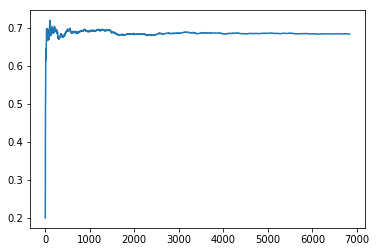

In [11]:
from matplotlib import pyplot

pyplot.plot(accuracy)